# Two-Fluids Solver

To find the solutions to Two-fluids TOV equations,
the hydrostatic equilibrium solutions, we have employed
numerical methods and used an open-source code, Collier [1] available at zenodo, which was modfied according our needs. The equations to be solved are:

\begin{equation}
\begin{split}
    \frac{dp_{BM}}{dr} & = - \big(p_{BM}+\rho_{BM}\big)\frac{\big( GM_{T}+4\pi r^3P_{T}\big)}{r\big(r- 2GM_{T}\big)}\\
    \frac{dp_{DM}}{dr} & = -\big(p_{DM}+\rho_{DM}\big)\frac{\big( GM_{T}+4\pi r^3P_{T}\big)}{r\big(r- 2GM_{T}\big)}.
\end{split}
\end{equation}
To solve two-fluid TOV equations, we have to impose two central conditions, at the center of the stars $m_{BM}(r = 0) = m_{DM}(r = 0) = 0$, and two boundary conditions at those points where the individual pressures drop down to zero, $p_{BM}(R_{BM}) = 0$ and $p_{DM}(R_{DM}) = 0$.

## Principal code

### First Part

In [6]:
from tqdm import tqdm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
from scipy.integrate import solve_ivp, odeint

from scipy.optimize import root
import warnings
import gc


#physical constants
el = 1.60217662*10**(-19)
c = 2.99792458*10**8
h = 6.63*10**(-34)
GSI = 6.67408*10**(-11)
hbar = 1.054571800 * 10**(-34)
G = GSI*((el*10**6/(hbar*c))**3 * (c**2/(el*10**6))**(-1) * (hbar/(el*10**6))**(2)) # Gravitational constant expressed in natural units


### Second Part

In [1]:
#A class of functions which calculate radii of the neutron star outputting (1 radius,2 radius, radius).
#Calling the class outputs a function, the input when calling in the function is the proportion of the central density at which the radius of the compact object lies.
class simple_rad_def:
    def __init__(self,proportion):
        self.proportion = proportion
    def __call__(self,invdNS1,invdNS2,mNS):
        if invdNS1[0][-1] ==0.0:
            R2 = interpolate_array(invdNS2[0][-1]*1e-9,invdNS2)
            R1 = 0.0
        elif invdNS2[0][-1] == 0.0:
            R1 = interpolate_array(4*145**4,invdNS1)
            R2 = 0.0
        else:
            R1 = interpolate_array(4*145**4,invdNS1)
            R2 = interpolate_array(invdNS2[0][-1]*1e-9,invdNS2)
        radiusmass = interpolate_array(max([R1,R2]),mNS)
        invmNS = np.array([mNS[1],mNS[0]])
        R = interpolate_array((1-self.proportion)*radiusmass,invmNS)
        return(R1,R2,R)
raddefault = simple_rad_def(1e-4)

### Third Part

In [3]:
#interpolates between 2 points to guess the value of a function between those points
def interpolate(x1,y1,x2,y2,xc):
    m = (y1-y2)/(x1-x2)
    return(y1+ m*(xc-x1))

#takes in an array np.array([xs,ys]) (xs and ys are arrays of points ) which represents a bunch of points x_i,y_i on some function, this function takes in an x value and
#interpolates y(x) on the smallest interval (x_i,x_i+1) in which the x value lies.
def interpolate_array(r, genericarray):
    rmin = genericarray[0,0]
    rmax = genericarray[0,-1]
    if rmin<r:
        L = len(genericarray[0])
        indexRANGE = [0,L-1]
        rRANGE = [rmin,rmax]
        for i in range(int(np.ceil(np.log2(L)))):
            indexchecked = int(np.ceil((indexRANGE[0]+indexRANGE[1])/2))
            rchecked = genericarray[0,indexchecked]
            if rchecked >= r:
                rRANGE = [rRANGE[0],rchecked]
                indexRANGE = [indexRANGE[0],indexchecked]
            elif rchecked < r:
                rRANGE = [rchecked,rRANGE[1]]
                indexRANGE = [indexchecked,indexRANGE[1]]
            if indexRANGE[1]-indexRANGE[0] == 1:
                break
        if r>= rmax:
            return(genericarray[1,-1])
        return(interpolate(rRANGE[0],genericarray[1,indexRANGE[0]],rRANGE[1],genericarray[1,indexRANGE[1]],r))

    elif rmin>=r:
        return(genericarray[1,-1])

#joins 2 arrays np.array([xs1,ys1]) np.array([xs2,ys2]) to np.array([xs,ys]) where xs = [xs_11, ...xs_1N,xs_21 ... xs_2M] and similar for ys
def joinarray(ar1,ar2):
    A = np.append(ar1[0],ar2[0])
    B = np.append(ar1[1],ar2[1])
    return(np.array([A,B]))

#takes in 2 2*N arrays assumed to have the same first row, outputs a new array with the same first row but the respective terms in the second row added together
#Useful for e.g. combining density profiles of matter and dark matter to get the total density profiles (densities add but radii do not)
def addarray(ar1,ar2):
    return(np.array([np.array(ar1[0]),np.array(ar1[1])+np.array(ar2[1])]))

#If no dark matter, this is taken as the equation of state for the dark matter
def ZEROFUNC(rho):
    return(0)

#numerically calculates the derivatives of pressure with respect to density for both the nuclear and dark matter components of the star. Outputs them in order (NM,DM)
def dp_drhos(EOS1,EOS2,rho1,rho2,drho1,drho2):
    return((EOS1(rho1+drho1/2)-EOS1(rho1-drho1/2))/drho1,(EOS2(rho2+drho2/2)-EOS2(rho2-drho2/2))/drho2)

#Input "variables" is an array [density1,mass1,density2,mass2], output is a similar array of the respective derivatives. Also takes in 2 EOS's for our 2 types of matter and the r coordinate at
#at which its evaluated.
def derivatives(r,variables,EOS1,EOS2,drho1,drho2):
    rho1 = variables[0]
    m1 = variables[1]
    rho2 = variables[2]
    m2 = variables[3]

    p1 = EOS1(rho1)
    p2 = EOS2(rho2)

    p = p1 + p2
    rho = rho1 + rho2
    m = m1 + m2

    dm1_dr = 4*np.pi*r**2 * rho1
    dm2_dr = 4*np.pi*r**2 * rho2

    dp1_drho1, dp2_drho2 = dp_drhos(EOS1,EOS2,rho1,rho2,drho1,drho2)

    dp1_dr = -(p1 + rho1)*(G*m+4*np.pi*G*r**3 *p)/(r*(r-2*G*m))
    dp2_dr = -(p2 + rho2)*(G*m+4*np.pi*G*r**3 *p)/(r*(r-2*G*m))

    if dp1_drho1 ==0:
        drho1_dr = 0
    else:
        drho1_dr = dp1_dr/dp1_drho1
    if dp2_drho2 == 0:
        drho2_dr = 0
    else:
        drho2_dr = dp2_dr/dp2_drho2

    return([drho1_dr,dm1_dr,drho2_dr,dm2_dr])



#This is probably the most important bit of the code - the class takes in all relevant information about the compact object and is capable of calculating various profiles (density, mass, pressure)
#it does this by solving the TOV equations. The class can also calculate the tidal love number of the neutron star, along with its mass, 1 and 2 matter masses, radius, 1 and 2 matter radii.
#BASIC USAGE INSTRUCTIONS: Object = Compact_Object(EOS1, EOS2in = EOS2) creates a compact object with the given 1 and 2 equations of state.
#Then, Object.profiles_data(central density of type 1 matter, [minimum r, maximum r],centraldensity2 = central density of type 2 matter) will produce information about the structure of the compact
#object which is saved inside Object.
class Compact_Object:
    def __init__(self,state_eq, EOS2in = ZEROFUNC):
        self.EqOState1 = state_eq
        self.EqOState2 = EOS2in
        self.RadDef = raddefault
        self.method = 'Radau'
        self.tol = 0.000001

    def Derivatives(self,r,variables):
        return(derivatives(r,variables,self.EqOState1,self.EqOState2,self.drho1,self.drho2))


    def profiles_data(self,centraldensity1,rspan,centraldensity2 = 0.0):
        self.centraldensity1 = centraldensity1
        self.centraldensity2 = centraldensity2
        self.drho1 = 10
        if centraldensity2 !=0:
            self.drho2 = centraldensity2*1e-8
        else:
            self.drho2 = 10
        rspan = (rspan[0],rspan[1])
        def EV(t,y):
            return(min([y[0]-4*145**4,y[2]-self.centraldensity2*10**(-8)]))
        EV.terminal = True

        def EV2(t,y):
            return(max([y[0]-4*145**4,y[2]-self.centraldensity2*10**(-8)]))
        EV2.terminal = True
        if min([centraldensity1,centraldensity2])!= 0.0:
            OUTinit = solve_ivp(self.Derivatives,rspan,[centraldensity1,4/3 * np.pi * rspan[0]**3*centraldensity1,centraldensity2,4/3 * np.pi * rspan[0]**3*centraldensity2],events = EV,method = self.method,atol = self.tol, rtol = self.tol)
            self.density1 = np.array([np.array(OUTinit.t),np.array(OUTinit.y[0])])
            self.density2 = np.array([np.array(OUTinit.t),np.array(OUTinit.y[2])])
            self.mass1 = np.array([np.array(OUTinit.t),np.array(OUTinit.y[1])])
            self.mass2 = np.array([np.array(OUTinit.t),np.array(OUTinit.y[3])])
        else:
            self.density1 = np.array([np.array([rspan[0]]),np.array([centraldensity1])])
            self.density2 = np.array([np.array([rspan[0]]),np.array([centraldensity2])])
            self.mass1 = np.array([np.array([rspan[0]]),np.array([0.0])])
            self.mass2 = np.array([np.array([rspan[0]]),np.array([0.0])])

        rspannew = (self.density1[0][-1],rspan[1])
        if self.density2[1][-1] != self.density1[1][-1]:
            if self.centraldensity1 == 0:
                OUTfin = solve_ivp(self.Derivatives,rspannew,[0.0,self.mass1[1][-1],self.density2[1][-1],self.mass2[1][-1]],events = EV2,method = self.method,atol = self.tol, rtol = self.tol)
                self.density1 = joinarray(self.density1,np.array([np.array(OUTfin.t),np.array(OUTfin.y[0])]))
                self.density2 = joinarray(self.density2,np.array([np.array(OUTfin.t),np.array(OUTfin.y[2])]))
            elif self.centraldensity2 == 0:
                OUTfin = solve_ivp(self.Derivatives,rspannew,[self.density1[1][-1],self.mass1[1][-1],0.0,self.mass2[1][-1]],events = EV2,method = self.method,atol = self.tol, rtol = self.tol)
                self.density1 = joinarray(self.density1,np.array([np.array(OUTfin.t),np.array(OUTfin.y[0])]))
                self.density2 = joinarray(self.density2,np.array([np.array(OUTfin.t),np.array(OUTfin.y[2])]))
            elif self.density2[1][-1]/self.centraldensity2 > self.density1[1][-1]/self.centraldensity1:
                OUTfin = solve_ivp(self.Derivatives,rspannew,[0.0,self.mass1[1][-1],self.density2[1][-1],self.mass2[1][-1]],events = EV2,method = self.method,atol = self.tol, rtol = self.tol)
                self.density1 = joinarray(self.density1,np.array([np.array(OUTfin.t),np.array(OUTfin.y[0])]))
                self.density2 = joinarray(self.density2,np.array([np.array(OUTfin.t),np.array(OUTfin.y[2])]))
            elif self.density2[1][-1]/self.centraldensity2 < self.density1[1][-1]/self.centraldensity1:
                OUTfin = solve_ivp(self.Derivatives,rspannew,[self.density1[1][-1],self.mass1[1][-1],0.0,self.mass2[1][-1]],events = EV2,method = self.method,atol = self.tol, rtol = self.tol)
                self.density1 = joinarray(self.density1,np.array([np.array(OUTfin.t),np.array(OUTfin.y[0])]))
                self.density2 = joinarray(self.density2,np.array([np.array(OUTfin.t),np.array(OUTfin.y[2])]))

            self.mass1 = joinarray(self.mass1,np.array([np.array(OUTfin.t),np.array(OUTfin.y[1])]))
            self.mass2 = joinarray(self.mass2,np.array([np.array(OUTfin.t),np.array(OUTfin.y[3])]))

        densityinverted2 = np.array([self.density2[1][::-1],self.density2[0][::-1]])
        densityinverted1 = np.array([self.density1[1][::-1],self.density1[0][::-1]])
        self.massT = addarray(self.mass1,self.mass2)
        self.R1,self.R2,self.R = self.RadDef(densityinverted1, densityinverted2,self.massT)

        pressuresm = []
        pressuresdm = []
        for i in range(len(self.density1[1])):
            pressuresm.append(self.EqOState1(self.density1[1][i]))
            pressuresdm.append(self.EqOState2(self.density2[1][i]))
        self.pressure1 = np.array([np.array(self.density1[0]),np.array(pressuresm)])
        self.pressure2 = np.array([np.array(self.density2[0]),np.array(pressuresdm)])
        self.pressureT = addarray(self.pressure1,self.pressure2)
        self.densityT = addarray(self.density1,self.density2)
        self.totalEOS = np.array([self.densityT[1],self.pressureT[1]])
        if self.R1 == 0.0:
            self.M1 = 0.0
        else:
            self.M1 = interpolate_array(self.R1, self.mass1)
        if self.R2 == 0.0:
            self.M2 = 0.0
        else:
            self.M2 = interpolate_array(self.R2, self.mass2)

        if self.M2 == None:
            plt.plot(self.density2[0],self.density2[1])
            plt.plot(self.density1[0],self.density1[1])
            plt.yscale("log")
            plt.xscale("log")
        self.M = interpolate_array(self.R,self.massT)



#Finds central densities in matter and dark matter subject to 2 constraints: The sum of the densities has a known fixed value, the proportion of the mass that is type 2 matter has a fixed value.
#This proves to be very useful for making neutron star stability curves with fixed 2 matter-1 matter mass ratios.
#The inputs are (in order) 1 matter EOS, 2 matter EOS, total central density, 2 matter lower bound central density, 2 matter upper bound central density,
#[minimum r evaluated, maximum r evaluated], True if want love number outputted, False if dont, tol = % tolerance on mass ratio, runtol = tolerance on ODE solving
#Outputs dictionary containing, central 2 type densities, 1 type matter radius, 2 type matter radius, radius, 1 mass, 2 mass, mass, tidal deformability (if lovenum = True)
def find_density_for_mass_ratio(EOS1,EOS2, ratio, tol,centraldensityT,rho2guessmin,rho2guessmax,rspan,lovenum,RunTol, cumulative = False,RadDef = raddefault, METHOD = 'Radau'):
    testol = (tol)**0.2
    rho2range = [rho2guessmin,rho2guessmax]

    if ratio == 0.0:
        rho2range = [0,0]

    ratios = []
    CAUGHT = False

    if cumulative != False and ratio!=0:
        rho0 = cumulative[-1]
        drho0 = cumulative[-1] - cumulative[-2]
        ddrho0 = (cumulative[-1] - cumulative[-2])-(cumulative[-2] - cumulative[-3])
        var = drho0+ddrho0/2
        j = Compact_Object(EOS1,EOS2in = EOS2)
        j.RadDef = raddefault
        j.method = METHOD
        j.tol = RunTol
        j.profiles_data(centraldensityT-rho0-var*(1+testol),rspan,centraldensity2 = rho0+var*(1+testol))
        testrat = []

        testrat.append(j.M2/j.M1)
        j = Compact_Object(EOS1,EOS2in = EOS2)
        j.method = METHOD
        j.tol = RunTol
        j.profiles_data(centraldensityT-rho0-var*(1-testol),rspan,centraldensity2 = rho0+var*(1-testol))
        testrat.append(j.M2/j.M1)
        testrat.sort()

        if testrat[0]<ratio<testrat[1]:
            CAUGHT = True
            rho2range = [rho0+var*(1-testol),rho0+var*(1+testol)]
            ratios = testrat


    if cumulative == False or CAUGHT == False:
        for i in rho2range:
            j = Compact_Object(EOS1,EOS2in = EOS2)
            j.RadDef = RadDef
            j.method = METHOD
            j.tol = RunTol
            j.profiles_data(centraldensityT-i,rspan,centraldensity2 = i)
            if j.M1 == 0.0 and i != centraldensityT:
                print("BROKEN! Central density 1: "+str(centraldensityT-i) +"Central density 2: "+str(i))
            if j.centraldensity1!= 0:
                ratios.append(j.M2/j.M1)
            else:
                ratios.append(1e100)
            del j
        ratios2 = ratios
        ratios.sort()
        rho2range.sort()
        if ratios2 != ratios:
            rho2range = [rho2range[1],rho2range[0]]

    while True:
        j = Compact_Object(EOS1,EOS2in = EOS2)

        if ratio == 0.0:
            rhotest = 0.0
        else:
            rhotest = (rho2range[0]+rho2range[1])/2

        j.RadDef = RadDef
        j.method = METHOD
        j.tol = RunTol
        j.profiles_data(centraldensityT-rhotest,rspan,rhotest)
        if j.M2/j.M1>=ratio:
            ratios = [ratios[0],j.M2/j.M1]
            rho2range[1] = rhotest
        elif j.M2/j.M1<ratio:
            ratios = [j.M2/j.M1,ratios[1]]
            rho2range[0] = rhotest
        if abs(ratios[1]-ratios[0])<=tol*ratio or abs(2*(rho2range[1]-rho2range[0])/(rho2range[0]+rho2range[1]))<tol*ratio*1e-3:
            break
    centraldensity1 = centraldensityT-(rho2range[0]+rho2range[1])/2
    return({'centraldensity1':centraldensity1,"centraldensity2":(rho2range[0]+rho2range[1])/2 , "DM":j.M2,"M1":j.M1,"M":j.M,"R":j.R,"R1":j.R1,"R2":j.R2,"ratio":j.M2/j.M1})

#given an array of pressures outputs: 1 radius, 2 radius, radius, 1 mass, 2 mass, mass, tidal deformability (if lovenum = True)
#Takes in 1 EOS, 2 EOS, array of densities, 2-1 mass ratio, rspan as before, lovenumb as before, tol as before, runtol as before, METHOD is method used to solve ODE, RadDef is radius
#definition function i.e. simple_rad_def element
def mass_radius_lovenum(EOS1, EOS2, rho2range, ratio = 0.0, rspan = [1e5,1e25], lovenum =False, tol = 1e-3, RadDef = raddefault, METHOD = 'Radau', RunTol = 1e-5):
    Rs = []
    Rs2 = []
    Rs1 = []
    Ms = []
    Ms1 = []
    Ms2 = []
    k2s = []
    centraldensity1s = []
    centraldensity2s = []
    centraldensityTs = []

    j = 0
    for i in tqdm(rho2range):
        j+=1
        if len(centraldensity2s)>2:
            thecumulative = centraldensity2s
        else:
            thecumulative = False
        J = find_density_for_mass_ratio(EOS1,EOS2,ratio,tol,i,i,0,rspan,lovenum,RunTol,cumulative = thecumulative,RadDef = RadDef, METHOD = METHOD)
        Rs.append(J["R"])
        Rs2.append(J["R2"])
        Rs1.append(J["R1"])
        Ms.append(J["M"])
        Ms1.append(J["M1"])
        Ms2.append(J["DM"])
        centraldensity2s.append(J["centraldensity2"])
        centraldensity1s.append(J["centraldensity1"])

    return((hbar*c/(el*1e9))*np.array(Rs),(hbar*c/(el*1e9))*np.array(Rs1),(hbar*c/(el*1e9))*np.array(Rs2),np.array(Ms)*1.6e-13/((3e8)**2 *1.989e30),np.array(Ms1)*1.6e-13/((3e8)**2 *1.989e30),np.array(Ms2)*1.6e-13/((3e8)**2 *1.989e30),np.array(centraldensity1s)/((10**15*hbar*c)/(el*10**6))**3,np.array(centraldensity2s)/((10**15*hbar*c)/(el*10**6))**3)

In [23]:
#EOS for boson stars.
class Bosonic_EOS:
    def __init__(self,m,l):
        self.m = m
        self.l = l
    def __call__(self,rho):
      return((self.m**4/(9*self.l))*(np.sqrt(1+(3*self.l/self.m**4)*rho)-1)**2)

# Bag EOS
class Bag:
  def __init__(self,B):
    self.B = B

  def __call__(self, rho):
    C = self.B**4

    if rho>0:
      p = (1/3)*(rho-4*C)
      return p
    else:
      return 0




## Illustrative example

In [ ]:
R99 = simple_rad_def(0.01)
Boson = Bosonic_EOS(400,np.pi)
Bag = Bag(145)

100%|██████████| 100/100 [00:36<00:00,  2.73it/s]


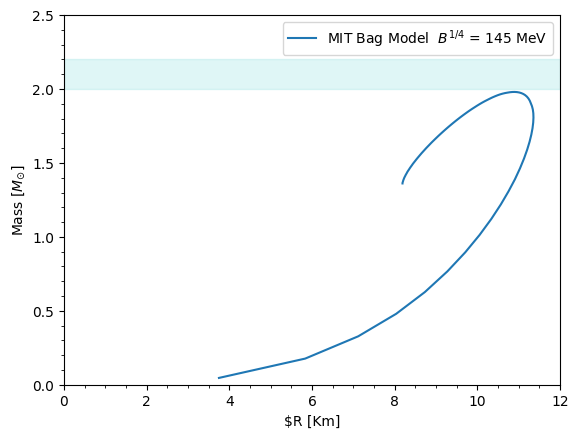

In [26]:
Rs,RsM,RsDM,Ms,MsM,MsDM,Ec1,Ec2 = mass_radius_lovenum(Bag,ZEROFUNC,np.logspace(9.26,11.3,100),rspan = [1e-1,1e60],ratio = 0 ,METHOD = 'RK23',RadDef = R99,RunTol = 1e-5,tol = 1e-4)
plt.plot(Rs,Ms, label = r'MIT Bag Model  $B^{1/4}$ = 145 MeV ')
plt.xlim(0,12)
plt.ylim(0,2.5)
plt.axhspan(2, 2.2, color='#96E2E2', alpha=0.3)

plt.xlabel(r'$R [Km]')
plt.ylabel(r'Mass $[M_{\odot}]$')
plt.legend(loc='best')
plt.minorticks_on()
plt.show()

## Future works


When speaking about stability condition for one fluid, the necessary, but not enough, condition for the stability of stars along the sequence equilibrium configuration is based on
the following inequality:
\begin{equation}
    \frac{\partial M(\rho_{{c}})}{\partial \epsilon_{c}} > 0\;.
\end{equation}
or equivalent to $\frac{\partial N(\rho_{{c}})}{\partial \epsilon_{c}} > 0$.
The last condition is no more valid by considering two fluid, for such case we need to generalize the above condition
\begin{equation}
 \begin{pmatrix}
 \delta N_{BM}\\
 \delta N_{DM}
\end{pmatrix} =  \begin{pmatrix}
 \frac{\partial N_{BM}}{\partial \epsilon^{c}_{BM}} & \frac{\partial N_{BM}}{\partial \epsilon^{c}_{DM}} \\
\frac{\partial N_{DM}}{\partial \epsilon^{c}_{BM}}  & \frac{\partial N_{DM}}{\partial \epsilon^{c}_{DM}}
\end{pmatrix} \begin{pmatrix}
 \delta \epsilon^{c}_{BM}\\
 \delta \epsilon^{c}_{DM}
\end{pmatrix}
\end{equation}
For a two-fluid configuration[3], the above matrix can
be diagonalized obtaining two independent sets of variables,$(ϵ_{A},N_{A})$ and $(ϵ_{B},N_{B})$  , with eigenvalues $\kappa_{A}$ and
$\kappa_{B}$. Stable configurations can only happen when both
eigenvalues, $\kappa_{A}$ and $\kappa_{B}$, are positive.  We are working in improve the above code to find the stability condition for two fluids.

# References

   [1] Michael Collier, Djuna Croon, Rebecca K. Leane, "Tidal Love Numbers of Novel and Admixed Celestial Objects", **Phys. Rev. D** 106, 123027 (2022). Doi : https://journals.aps.org/prd/abstract/10.1103/PhysRevD.106.123027

   [2] Open-Source code to solve the tidal deformability of a gravity bound sphere of perfect fluid containing upto two fluids coupled through gravity only. https://zenodo.org/records/6584578.

   [3] Maurício Hippert, Emily Dillingham, Hung Tan, David Curtin, Jacquelyn Noronha-Hostler, and Nicolás Yunes, "Dark matter or regular matter in neutron stars? How to tell the difference from the coalescence of compact objects", **Phys. Rev. D** 107, 115028 (2023), Doi : https://journals.aps.org/prd/abstract/10.1103/PhysRevD.107.115028

